# Deriving dark matter constraints from dwarf galaxies with a data-driven approach

In this notebook, we show how to work with the provided scripts in order to reproduce the analyses presented in [arXiv:1803.05508](https://iopscience.iop.org/article/10.1088/1475-7516/2018/10/029) and [arXiv:2002.01229](https://iopscience.iop.org/article/10.1088/1475-7516/2020/09/004).

The general idea of this approach is to improve on the standard Fermi-LAT analysis of dwarf spheroidal galaxies aiming to constrain the parameters of particle dark matter. The main difference arises from the treatment of the expected astrophysical gamma-ray background at the position of a particular dwarf galaxy. While the Fermi-LAT collaboration relies on a conventional assessment of the uncertainty of this background component via a selection of various models, the approach presented here is based on a data-driven technique utilisng the whole-sky data and an optimisation procedure of the expected background levels.

<b> Note: </b> All Fermi-LAT data that comes with this library is the setup used for [arXiv:2002.01229](https://iopscience.iop.org/article/10.1088/1475-7516/2020/09/004). In this version of the code, the user is not able to replace these data with a custom data set and to repeat the optimisation routine on such data. We stress here the specifications of the provided LAT data:

- time period: August 4, 2008 (week 9) to June 7, 2018 (week 522),
- event class: SOURCE (P8R2),
- event type: FRONT+BACK,
- energy range: 500 MeV to 500 GeV (24 logarithmically spaced energy bins),
- region of interest: all sky ($0.1^{\circ}\times0.1^{\circ}$ pixels in plate carrée (CAR) projection),
- quality cuts: (DATA_QUAL>0) && (LAT_CONFIG==1),
- zenith angle cut: $>90^{\circ}$.

<b> Outline: </b> In this notebook, we first introduce the handling of the $J$-factor and background profiling routines of this software package. This part of the code can be used to analyse single dwarfs galaxies as well as a selection of dwarfs whose statistical power is stacked to derive a combined upper limit on the relevant dark matter parameters. We show how to manipulate the data input the user is enabled to provide in order to customise the code according to their needs. <br>
In the second part, we use the default parameters of the scripts and input data files to reproduce Fig. 5 of [arXiv:2002.01229](https://iopscience.iop.org/article/10.1088/1475-7516/2020/09/004). 

## Setup

  <b>1.  Python modules</b> <br>
  ***
<b>Import all necessary scripts</b> required for the analysis and <b>define the path</b> where the folder with all code is stored.

In [1]:
from LAT_dwarfs import dwarf_profiling as dprof
from LAT_dwarfs import dwarf_setlimits as dlim
from LAT_dwarfs import dwarf_plot as dplot
import multiprocessing as mp
import os

##Set the path to the working directory of the folder containing the scripts.
source_path = "./"

<b> 2. Dwarf data table </b> <br>
***
The heart of the analysis is a dwarf spheroidal galaxy summary file, which lists all relevant properties of the dwarfs that may be included in a run of the script. It is called:<br>
<br>
      `default_dwarf_summary_table.dat`<br>
<br>
This table lists the following quantities with some example entries:<br>

| dwarf name | position<br>(2 columns: Galactic longitude/latitude in degree) | $J$-factor<br>(2 columns: $\log_{10}J$ and $\log_{10}\sigma_J$ ) | LAT exposure at dwarf position for each of the 24 energy bins \[cm$^2$ s\] |
| :---: | :---: | :---: | :---: |
| Carina | (260.11, -22.22) | (17.87, 0.07) | 3.32252280e+11 3.61144365e+11 3.84963682e+11 4.14092865e+11 4.31196305e+11 4.40936021e+11 4.43478687e+11 4.40878279e+11 4.33701602e+11 4.36104907e+11 4.37812239e+11 4.37920453e+11 4.37857380e+11 4.36889956e+11 4.42446218e+11 4.48922810e+11 4.49737009e+11 4.48386825e+11 4.47037663e+11 4.45163380e+11 4.44010471e+11 4.43578722e+11 4.43483841e+11 4.40888340e+11 |
| Draco | (86.37, 34.72) | (18.69, 0.05) | 4.02486981e+11 4.37197565e+11 4.66289039e+11 5.01611222e+11 5.22042808e+11 5.33966847e+11 5.37196898e+11 5.33446559e+11 5.25155909e+11 5.28062124e+11 5.30240148e+11 5.30246919e+11 5.30313578e+11 5.29370038e+11 5.35597303e+11 5.43548191e+11 5.44546484e+11 5.42970131e+11 5.41249779e+11 5.39293537e+11 5.38040048e+11 5.37676589e+11 5.37632121e+11 5.34474252e+11 |
| LeoII | (220.17, 67.23) | (17.48, 0.09) | 3.00596565e+11 3.28264033e+11 3.52440798e+11 3.81887576e+11 3.99504645e+11 4.07639952e+11 4.08402258e+11 4.03732760e+11 3.93886598e+11 3.93909777e+11 3.96024602e+11 3.96044668e+11 3.94370130e+11 3.91737383e+11 4.02795175e+11 4.11510480e+11 4.12851105e+11 4.11549393e+11 4.10860748e+11 4.08407909e+11 4.07279034e+11 4.06540708e+11 4.06509656e+11 4.02658200e+11 |

The currently available dwarfs and their properties are taken from the Fermi-LAT collaboration's publication [arXiv:1611.03184](https://iopscience.iop.org/article/10.3847/1538-4357/834/2/110). The user is free to change these values to their likings. <b> Adding dwarfs would require to re-run the background optimisation routine because these positions are not yet part of the provided data tables. Hence, it is currently not possible to do so. The ordering of the dwarfs must not be changed because there are further auxiliary files that follow the same ordering but are not supposed to be touched. </b>

<b> 3. User-defined DM spectrum files </b> <br>
***
By default, the analysis uses the WIMP dark matter differential gamma-ray spectra discussed in the "PPPC 4 DM ID - A Poor Particle Physicist Cookbook for Dark Matter Indirect Detection" [arXiv:1012.4515](https://iopscience.iop.org/article/10.1088/1475-7516/2011/03/051), which come alongside the code with either electroweak corrections (`AtProduction_gammas.dat`) or without them (`AtProductionNoEW_gammas.dat`). Currently, three different spectra may be accessed: `["bb", "WW", "tautau"]`. The choice has to be manually entered in the script `dwarf_profiling.py` by setting the argument `annihil_channel` of the function `integrate_DM_dNdE`. The default is `"bb"`.<br>
<br>
Alternatively, the user has the option to derive constraints on the parameters of any dark matter model as long as they provide a table of the differential gamma-ray spectrum per annihilation event $\mathrm{d}N/\mathrm{d}E$, i.e. the number of gamma rays produced with a particular energy $E$ in a single annihilation event. The expected format of such a spectrum is a simple plain text document with three columns:

| DM mass $m_{\mathrm{DM}}$ | energy E \[GeV\] | $\frac{\mathrm{d}N}{\mathrm{d}E}$ \[GeV$^{-1}$\]|
| :---: | :---: | :---: |
| 50.0 | 0.001 | 0.01 |
| 50.0 | 0.0015 | 0.012 |
| ... | ... | ... |
| 50.0 | 50.0 | 1e-9 |
| 60.0 | 0.001 | 0.0101 |
| ... | ... | ... |

Note that the dark matter mass column repeats in each row the mass value for each entry in the two associated columns. <br>
<b> Note: </b> Setting upper limits at different dark matter masses requires the user to provide the gamma-ray spectrum at the requested dark matter mass. There is no interpolation implemented.

### Running the dSph profiling over $J$-factors and/or background

To initiate the dwarf profiling, we first import the prepared dwarf data table:

In [2]:
dwarf_data = dprof.getdSphs_data_from_table(source_path + "default_dwarf_summary_table.dat", 29)
## the second argument "29" refers to the number of columns in the dwarf table

To run the main routine of `dwarf_profiling.py` we need to specify secondary specifications of the run:

- Which dwarfs are supposed to be considered?

In [3]:
dwarf_list = ["Draco", "LeoII"] ## This list may contain a single or multiple dwarfs. If there are multiple dwarfs,
                                ## stacking is automatically activated.

- Do you want to include empirical $J$-factors derived and utilised in [arXiv:2002.01229](https://iopscience.iop.org/article/10.1088/1475-7516/2020/09/004) that rely on a data-driven shape of the J-factors’ empirical probability distribution? The relevant data may be found in the folder `Jfactors` and it concers the dwarfs: "Draco", "Carina", "Fornax", "LeoI", "LeoII", "Sculptor", "Sextans" and "UrsaMinor". If this option is selected, all dwarfs, for which no empirical $J$-factor results are available, take average $J$-factor value and uncertainty from the dwarf table.

In [4]:
emp_jlist = source_path + "Jfactors"
is_empirical = True

- Do you want to use a user-defined dark matter annihilation spectrum? If so, import its path otherwise set it to 'None'.

In [5]:
spectrum = None

- At which dark matter masses do you want to evaluate the profiled likelihood? This has to be specified via a simple plain text file which lists all <b> masses in GeV </b> line by line.

In [6]:
filescan = source_path + "scan_DM_mass.dat"

- What is the range of annihilation cross-sections that is used to scan the profiled likelihood function (should be large enough to encompass the cross-section value at which the final limit is being set)?

In [7]:
svmin = 1e-27 ##cm^3/s
svmax = 1e-22 ##cm^3/s

- Specify the data with the optimised background counts (already done; not to be changed by the user)!

In [8]:
bkg_path = source_path + "bkg_data"

- The code is parallelised, the user may specify the number of threads to run in parallel.

In [9]:
ncpu = mp.cpu_count() ## maximal number of available threads on your computer

- Do you want to profile only over the $J$-factor uncertainty (`"J"`) or over background and $J$-factors at the same time (`"JB"`)? <br> <b> Besides this choice , the user needs to create (if running the code for the first time) a new folder where the profiling results are stored. The code assumes the existence of such folders so that their name tags have to be either: `profiling_caseJ` or `profiling_caseJB` depending on the user's choice.</b>

In [10]:
case = "J"
### do not forget to run `mkdir profiling_caseJ` if you run the script for the first time
os.system('mkdir ' + source_path + 'profiling_caseJ') # os.system('mkdir ' + source_path + 'profiling_caseJB')

Now we are ready to run the main routine of the profiling script:

In [40]:
dprof.profiling(dwarf_data, 
                dwarf_list = dwarf_list,
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

++++ this is dwarf # ++++ this is dwarf # ++++ this is dwarf # ++++ this is dwarf # ++++ this is dwarf # ++++ this is dwarf # ++++ this is dwarf # ++++ this is dwarf #   

### Exploiting the tabulated profiled likelihood values to set upper limits

Now we have generated several tables of profiled likelihood values for all dark matter masses specified in the file `"scan_DM_mass.dat"` using the results from the two dwarfs "Draco" and "LeoII". We now evaluate these tables with the goal to set upper limits -- of a specific confidence level -- on the dark matter pair-annihilation cross-section by calling the routines of `dwarf_setlimits.py`.<br>
<br>
To this end, we have to define the confidence level of the upper limits by declaring the log-likelihood ratio:

In [11]:
deltaEXCL = 3.84 ## 95% confidence level

We also have to specify the path to the folder that contains the generated profiled likelihood tables. <b> Like in the profiling case, if this is the first time the code is run, the user must first create a folder `mkdir excl_limits_caseJ` or `mkdir excl_limits_caseJB` depending on the chosen case. </b>

In [16]:
root = source_path + "profiling_caseJ/"
### Do not forget to create the required folders where the limits are stored as text files!
os.system('mkdir ' + source_path + 'excl_limits_caseJ') # os.system('mkdir ' + source_path + 'excl_limits_caseJB')

Now we can run the limit setting routine:

In [15]:
dlim.limits(case = case, 
             ndwarf = dwarf_list, 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

+++++++++++++++  This is case  J  ++++++++++++++++++++++
File =  sv_caseJ_Draco+LeoII_0.dat
 sv excl =  9.217145848418982e-27
File =  sv_caseJ_Draco+LeoII_1.dat
 sv excl =  1.0294405236253758e-26
File =  sv_caseJ_Draco+LeoII_2.dat
 sv excl =  1.6166680745349672e-26
File =  sv_caseJ_Draco+LeoII_3.dat
 sv excl =  2.138616992939206e-26
File =  sv_caseJ_Draco+LeoII_4.dat
 sv excl =  2.6341594756343903e-26
File =  sv_caseJ_Draco+LeoII_5.dat
 sv excl =  3.130758475439502e-26
File =  sv_caseJ_Draco+LeoII_6.dat
 sv excl =  3.644652826188607e-26
File =  sv_caseJ_Draco+LeoII_7.dat
 sv excl =  4.179863661428191e-26
File =  sv_caseJ_Draco+LeoII_8.dat
 sv excl =  4.7442505516082805e-26
File =  sv_caseJ_Draco+LeoII_9.dat
 sv excl =  5.329330663090818e-26
File =  sv_caseJ_Draco+LeoII_10.dat
 sv excl =  5.931674589932798e-26
File =  sv_caseJ_Draco+LeoII_11.dat
 sv excl =  6.556644971410913e-26
File =  sv_caseJ_Draco+LeoII_12.dat
 sv excl =  7.19756703787578e-26
File =  sv_caseJ_Draco+LeoII_13.dat
 sv 

### Plotting the upper limits

The analysis library also contains a short script to create plots of the derived upper limits. This routine is designed to use the text files stored in the folders `excl_limits_caseJ` or `excl_limits_caseJB` and plot them in a loglog-style.<br>
The user may additionally provide the respective upper limits of single dwarfs if the main result is a combined limit from several stacked dwarfs.

In [11]:
root = source_path + "excl_limits_caseJ/"
plot_type = "single" #if `single' only the file corresponding to the specified combination of dwarfs is plotted,
                     #if 'all', the routine assumes that besides the file with stacked dwarfs other files exist that
                     #contain the limits solely based on one of the dwarfs in the original list.

If we run the plotting routine, we obtain the following plot (saved as a .pdf):

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


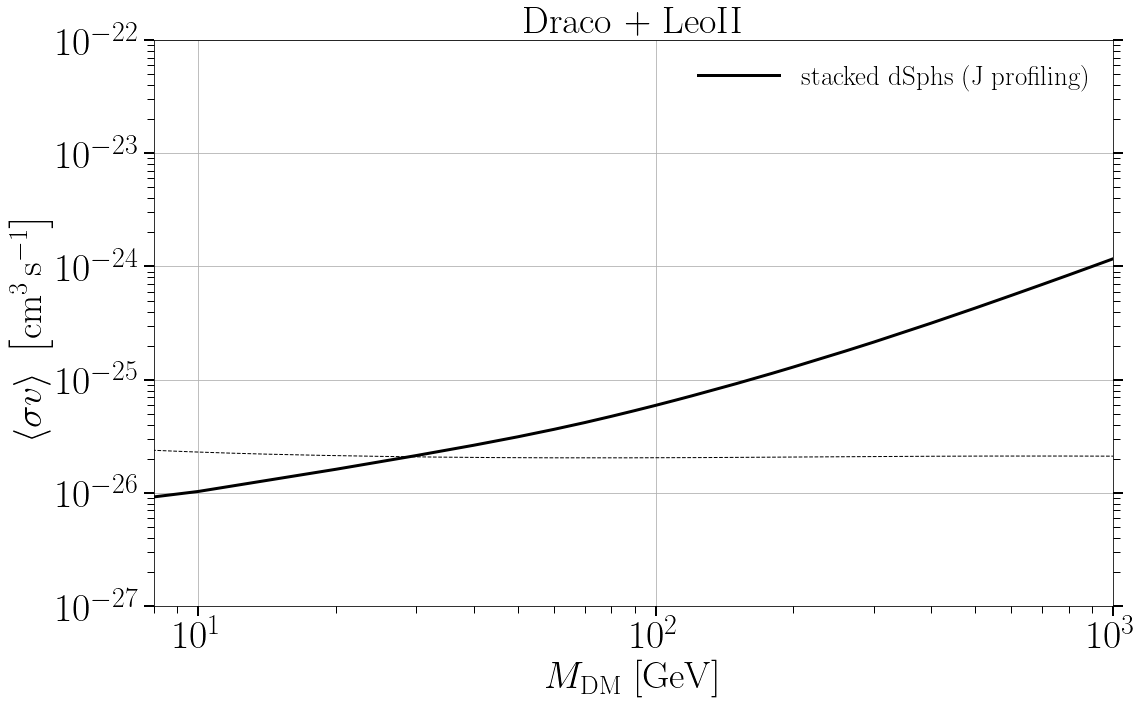

In [12]:
dplot.plot_limits_scan(root = root, 
                       dwarf_list = dwarf_list, 
                       case = case, 
                       plot_type = plot_type,
)

## Application: Reproducing Fig. 5 of [arXiv:2002.01229](https://iopscience.iop.org/article/10.1088/1475-7516/2020/09/004)

The results in this publication are based on four prominent dwarf spheroidal galaxies: Draco, Sculptor, LeoII and UrsaMinor. For these dwarfs, we have empirical $J$-factors, which we will employ in order to obtain annihilation cross-section upper limits rather agnostic on any a priori assumptions about the functional shape of background or $J$-factor probability distributions with respect to each dwarf.

The final plots contain the combined as well as single dwarf limits so that we have to derive all of them before plotting them all together!

### Left panel: $J$-profiling

In [5]:
case = "J"
dwarf_list = ["Draco", "LeoII", "Sculptor", "UrsaMinor"]

dwarf_data = dprof.getdSphs_data_from_table(source_path + "default_dwarf_summary_table.dat", 29)
emp_jlist = source_path + "Jfactors"
is_empirical = True
spectrum = None
filescan = source_path + "scan_DM_mass.dat"
svmin = 1e-27 
svmax = 1e-22 
bkg_path = source_path + "bkg_data"
ncpu = mp.cpu_count() 

dprof.profiling(dwarf_data, 
                dwarf_list = dwarf_list,
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

Repeating the same lines for each single dwarf galaxy:

In [16]:
dprof.profiling(dwarf_data, 
                dwarf_list = ["Draco", ],
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

dprof.profiling(dwarf_data, 
                dwarf_list = ["LeoII", ],
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

dprof.profiling(dwarf_data, 
                dwarf_list = ["Sculptor", ],
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

dprof.profiling(dwarf_data, 
                dwarf_list = ["UrsaMinor", ],
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

++++ this is dwarf # ++++ this is dwarf # ++++ this is dwarf # ++++ this is dwarf # 

Now, we can derive upper limits for each dwarf galaxy and their combined, stacked limits:

In [6]:
deltaEXCL = 3.84 ## 95% confidence level
root = source_path + "profiling_caseJ/"

dlim.limits(case = case, 
             ndwarf = dwarf_list, 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

#### Single dwarfs

dlim.limits(case = case, 
             ndwarf = ["UrsaMinor", ], 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

dlim.limits(case = case, 
             ndwarf = ["Draco", ], 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

dlim.limits(case = case, 
             ndwarf = ["Sculptor", ], 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

dlim.limits(case = case, 
             ndwarf = ["LeoII", ], 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

Everything can now be combined into a single plot reproducing the left panel of Fig. 5:

In [7]:
root = source_path + "excl_limits_caseJ/"
plot_type = "all"

dplot.plot_limits_scan(root = root, 
                       dwarf_list = dwarf_list, 
                       case = case, 
                       plot_type = plot_type,
)

![](FermiLAT_J_profiling_excl_limits_stacked_dSph_Draco+LeoII+Sculptor+UrsaMinor_w_single_dwarfs.png)

### Right panel: JB - profiling

In [8]:
case = "JB"
os.system('mkdir ' + source_path + 'profiling_caseJB')    ### creating the required folder
dwarf_list = ["Draco", "LeoII", "Sculptor", "UrsaMinor"]

dwarf_data = dprof.getdSphs_data_from_table(source_path + "default_dwarf_summary_table.dat", 29)
emp_jlist = source_path + "Jfactors"
is_empirical = True
spectrum = None
filescan = source_path + "scan_DM_mass.dat"
svmin = 1e-27 
svmax = 1e-22 
bkg_path = source_path + "bkg_data"
ncpu = mp.cpu_count() 

dprof.profiling(dwarf_data, 
                dwarf_list = dwarf_list,
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

In [ ]:
dprof.profiling(dwarf_data, 
                dwarf_list = ["Draco", ],
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

dprof.profiling(dwarf_data, 
                dwarf_list = ["LeoII", ],
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

dprof.profiling(dwarf_data, 
                dwarf_list = ["Sculptor", ],
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

dprof.profiling(dwarf_data, 
                dwarf_list = ["UrsaMinor", ],
                emp_jlist = emp_jlist,
                is_empirical = is_empirical,
                spectrum = spectrum,
                filescan = filescan,
                svmin = svmin,
                svmax = svmax,
                bkg_path = bkg_path,
                ncpu = ncpu,
                case = case,
)

In [ ]:
deltaEXCL = 3.84 ## 95% confidence level
root = source_path + "profiling_caseJB/"
os.system('mkdir ' + source_path + 'excl_limits_caseJB')

dlim.limits(case = case, 
             ndwarf = dwarf_list, 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

#### Single dwarfs

dlim.limits(case = case, 
             ndwarf = ["UrsaMinor", ], 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

dlim.limits(case = case, 
             ndwarf = ["Draco", ], 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

dlim.limits(case = case, 
             ndwarf = ["Sculptor", ], 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

dlim.limits(case = case, 
             ndwarf = ["LeoII", ], 
             deltaEXCL = deltaEXCL, 
             filescan = filescan, 
             root = root,
)

In [9]:
root = source_path + "excl_limits_caseJB/"
plot_type = "all"

dplot.plot_limits_scan(root = root, 
                       dwarf_list = dwarf_list, 
                       case = case, 
                       plot_type = plot_type,
)

![](FermiLAT_JB_profiling_excl_limits_stacked_dSph_Draco+LeoII+Sculptor+UrsaMinor_w_single_dwarfs.png)

## Final remarks

The routines and scripts that have been called in this interactive jupyter notebook, may also be run from the command line by providing parser arguments. In the following we list the parser arguments that the user may specify.

### `dwarf_profiling.py`<br>

The dwarf list is a single string of the name tags of all dwarfs joined by a `+`.

```python
    parser.add_option("-c", "--case", dest="case", help="Case: J - profiling only the J-factor; JB - combined profiling of dSph J-factor and background contribution", metavar="MODE", type='str', default = "J")
    
    parser.add_option("-l", "--dictionary", dest="dwarf_dict", help="dSph dict", metavar="DICT", type='str', default = "default_dwarf_summary_table.dat")

    parser.add_option("-d", "--dwarfs", dest="dwarf_list", help="dSph list", metavar="DWARF", type='str', default = "Draco")
    
    parser.add_option("-j", "--jfactors", dest="j_type", help="Case: 1 -- use data-driven J-factors for those dwarfs for which they are available; 0 -- use the values of Table 1 in arXiv:1611.03184 of the Fermi-LAT collaboration", metavar="EMP", type=int, default = 1) 
    
    parser.add_option("--svmin", dest="svmin", help="svmin for scan", metavar="SVMIN", type='float', default =1e-27)
    parser.add_option("--svmax", dest="svmax", help="svmax for scan", metavar="SVMAX", type='float', default =1e-22)
    parser.add_option("--filescan", dest="filescan", help="Sample points file", metavar="SCAN", type='str', default = "misc/scan_DM_mass.dat")
    parser.add_option("--emp_J", dest="j_path", help="relative path to the folder with data-driven J-factor values per dwarf", metavar="JPATH", type='str', default = './Jfactors')
    parser.add_option("--lnB", dest="bkg_path", help="relative path to the folder with measured and predicted background events at a chosen dwarf position", metavar="BKGPATH", type='str', default = './bkg_data')
    parser.add_option("--spectrum", dest="spectrum", help="differential DM gamma-ray spectrum file\nenergies expected in GeV", metavar="DNDE", type='str', default=None)
```
Example `python3 dwarf_profiling.py -c J -d Draco+LeoII+LeoI -j 0`<br>
This runs the profiling with $J$-factor profiling via the stacked dwarf galaxies Draco, LeoI and LeoII using only the Fermi-LAT average $J$-factors and their uncertainties. The remaining default parameters are all in line with the input we have provided above.

### `dwarf_setlimits.py`

```python
    parser.add_option("-c", "--case", dest="case", help="Case: J - profiling only the J-factor; JB - combined profiling of dSph J-factor and background contribution", metavar="MODE", type='str', default = "J")
    
    # Sample dSph for either single case or combined limits
    parser.add_option("-d", "--dwarfs", dest="dwarf_list", help="dSph list", metavar="DWARF", type='str', default = "Draco")
    parser.add_option("--deltaEXCL", dest="deltaEXCL", help="delta in LogL for exclusion limit calculation", metavar="deltaEXCL", type='float', default =3.84)
    parser.add_option("--filescan", dest="filescan", help="Sample points list", metavar="SCAN", type='str', default = "misc/scan_DM_mass.dat")
```

### `dwarf_plot.py`

```python
    parser.add_option("-d", "--dwarf", dest="dwarf_list", help="dSph list, multiple dwarfs are joined with a '+'", metavar="NDWARF", type='str', default = "Draco")
    
    parser.add_option("-c", "--case", dest="case", help="Case: J - profiling only the J-factor; JB - combined profiling of dSph J-factor and background contribution", metavar="MODE", type='str', default = "J")
    
    # Sample dSph for either single case or combined limits
    parser.add_option("--type", dest="plot_type", help="Case: all -- plot stacked limit and all single dwarf limits which are part of the stacked limit; single -- plot only the limit from the input combination of dwarfs", metavar="CASE", type='str', default ="all")
```